In [1]:
# import system libs
import os
from glob import glob

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from lg2unetr import SwinUNETR
from monai.losses import DiceLoss
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import cv2
# import pandas as pd
# import numpy as np
import sys
sys.path.append('../Unet0')
from utils import  create_dataloader, dice_coef, iou_coef
from torch.utils.tensorboard import SummaryWriter
# import data handling tools
import cv2
import numpy as np
import pandas as pd
# import seaborn as sns
# %matplotlib inline
# from skimage.color import rgb2gray
# from skimage.morphology import label
# from skimage.transform import resize
# from skimage.io import imread, imshow, concatenate_images
# sns.set_style('darkgrid')

%reload_ext autoreload
%autoreload 2

/home/vscode/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
def create_df(data_dir):
    images_paths = []
    masks_paths = sorted(glob(f'{data_dir}/*/*_mask*'))

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
data_dir = '/workspaces/data/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

In [4]:
len(train_df), len(valid_df), len(test_df)

(3143, 393, 393)

In [5]:
# %load_ext autoreload
# %autoreload 2
#from utils import create_dataloader
BATCH_SIZE = 8
train_loader = create_dataloader(train_df, batch_size=BATCH_SIZE, augment=True, num_workers=16)
valid_loader = create_dataloader(valid_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)
test_loader = create_dataloader(test_df, batch_size=BATCH_SIZE, augment=False, num_workers=16)


/home/vscode/.local/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


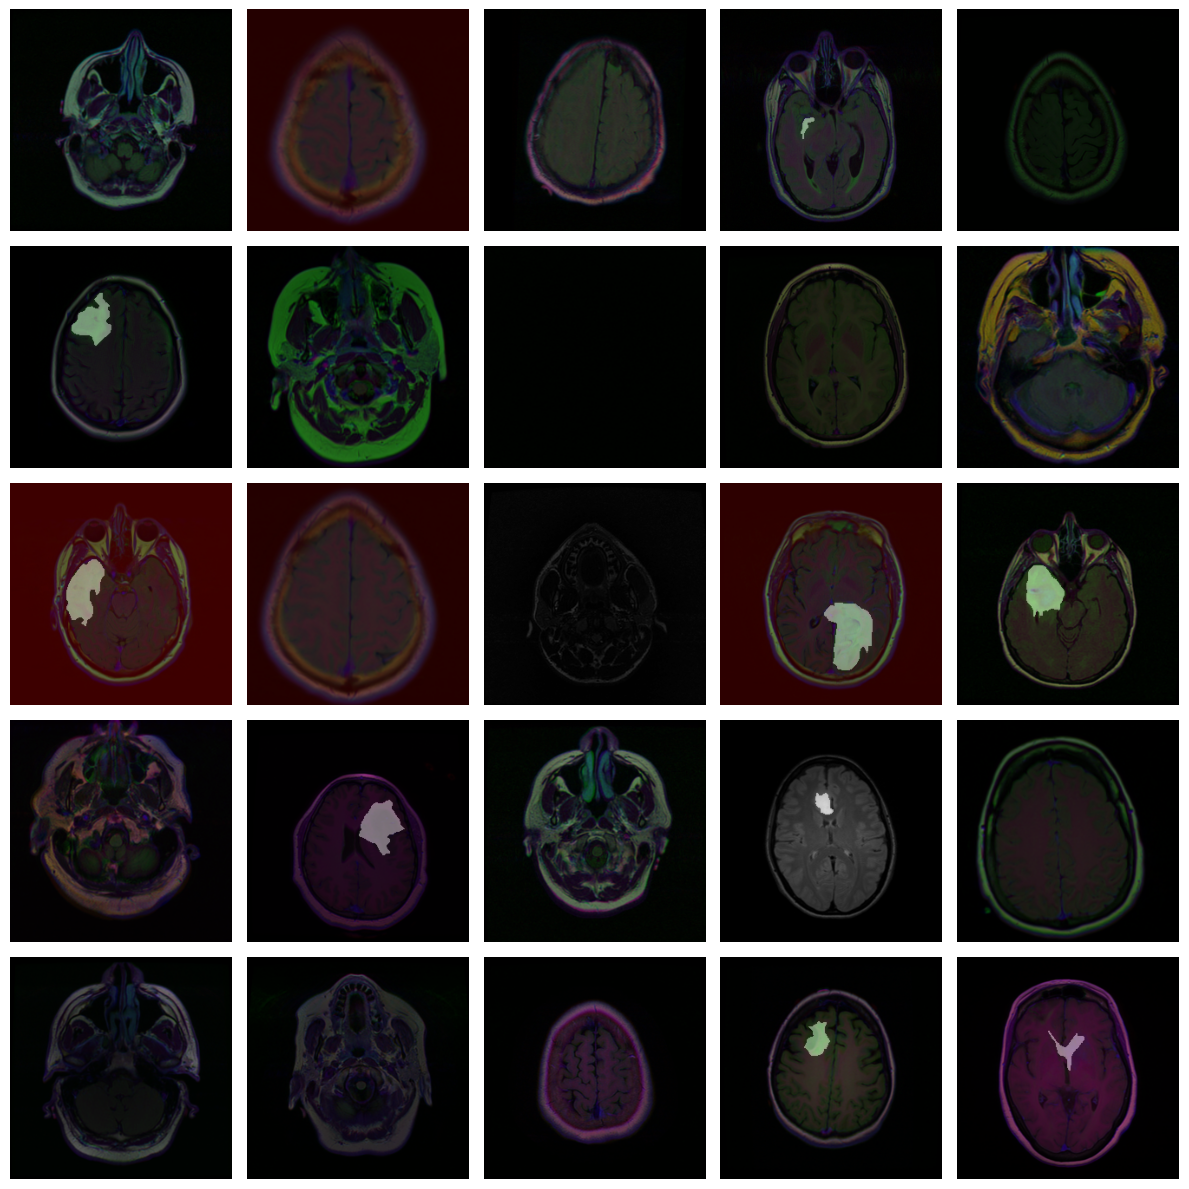

In [6]:
from utils import show_images
show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = UNet(in_channels=3, out_channels=1).to(device)
model = SwinUNETR(
        img_size=(256,256),
        in_channels=3,
        out_channels=1,
        feature_size=24,
        use_checkpoint=False,
        spatial_dims=2
    ).to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001)
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
criterion = dice_loss  # al

def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    for images, masks in tqdm(dataloader, desc='Training'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)#round2: should be sigmoid activation
        # outputs = torch.sigmoid(outputs)  ## Not needed
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_dice += dice_coef(masks,torch.sigmoid(outputs),smooth=1).item()
        total_iou += iou_coef(masks, torch.sigmoid(outputs),smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n



def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Validating'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion( outputs, masks)
            total_loss += loss.item()
            total_dice += dice_coef(masks, torch.sigmoid(outputs),smooth=1).item()
            total_iou += iou_coef(masks, torch.sigmoid(outputs),smooth=1).item()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n


In [8]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 256, 256))

Layer (type:depth-idx)                                  Output Shape              Param #
SwinUNETR                                               [8, 1, 256, 256]          --
├─SwinTransformer: 1-1                                  [8, 24, 128, 128]         --
│    └─PatchEmbed: 2-1                                  [8, 24, 128, 128]         --
│    │    └─Conv2d: 3-1                                 [8, 24, 128, 128]         312
│    └─Dropout: 2-2                                     [8, 24, 128, 128]         --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─BasicLayer: 3-2                             [8, 48, 64, 64]           20,598
│    └─ModuleList: 2-4                                  --                        --
│    │    └─BasicLayer: 3-3                             [8, 96, 32, 32]           137,304
│    └─ModuleList: 2-5                                  --                        --
│    │    └─BasicLayer: 3-4                       

In [9]:
# import os
import datetime

epochs = 120
best_val_loss = float('inf')
save_path = 'unet1.pth'

log_dir = os.path.join("/workspaces/data/MegaGen/UNet", 
                       "unet_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir=log_dir)
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
}



In [10]:
print ("device:",next(model.parameters()).device)
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    train_loss, train_dice, train_iou = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_dice, val_iou = validate(model, valid_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)

    # Log to TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Dice/Train", train_dice, epoch)
    writer.add_scalar("Dice/Val", val_dice, epoch)
    writer.add_scalar("IoU/Train", train_iou, epoch)
    writer.add_scalar("IoU/Val", val_iou, epoch)

    # Save to history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)


device: cuda:0

Epoch 1/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


Train Loss: 0.8810, Dice: 0.1426, IoU: 0.0810
Val   Loss: 0.8153, Dice: 0.2374, IoU: 0.1431
Validation loss improved (inf → 0.8153). Saving model...

Epoch 2/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


Train Loss: 0.7784, Dice: 0.3543, IoU: 0.2290
Val   Loss: 0.7525, Dice: 0.3869, IoU: 0.2550
Validation loss improved (0.8153 → 0.7525). Saving model...

Epoch 3/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


Train Loss: 0.7474, Dice: 0.4441, IoU: 0.3055
Val   Loss: 0.7482, Dice: 0.4807, IoU: 0.3414
Validation loss improved (0.7525 → 0.7482). Saving model...

Epoch 4/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Train Loss: 0.7367, Dice: 0.5130, IoU: 0.3685
Val   Loss: 0.7380, Dice: 0.4952, IoU: 0.3541
Validation loss improved (0.7482 → 0.7380). Saving model...

Epoch 5/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.41it/s]


Train Loss: 0.7324, Dice: 0.5537, IoU: 0.4095
Val   Loss: 0.7179, Dice: 0.5547, IoU: 0.4115
Validation loss improved (0.7380 → 0.7179). Saving model...

Epoch 6/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.24it/s]


Train Loss: 0.7278, Dice: 0.5673, IoU: 0.4250
Val   Loss: 0.7333, Dice: 0.5571, IoU: 0.4146

Epoch 7/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Train Loss: 0.7257, Dice: 0.5786, IoU: 0.4353
Val   Loss: 0.7150, Dice: 0.5825, IoU: 0.4459
Validation loss improved (0.7179 → 0.7150). Saving model...

Epoch 8/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


Train Loss: 0.7228, Dice: 0.5928, IoU: 0.4499
Val   Loss: 0.7169, Dice: 0.6222, IoU: 0.4853

Epoch 9/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.67it/s]


Train Loss: 0.7220, Dice: 0.6026, IoU: 0.4579
Val   Loss: 0.7116, Dice: 0.6130, IoU: 0.4625
Validation loss improved (0.7150 → 0.7116). Saving model...

Epoch 10/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.30it/s]


Train Loss: 0.7191, Dice: 0.6208, IoU: 0.4822
Val   Loss: 0.7268, Dice: 0.6576, IoU: 0.5160

Epoch 11/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.49it/s]


Train Loss: 0.7192, Dice: 0.6221, IoU: 0.4834
Val   Loss: 0.7109, Dice: 0.6564, IoU: 0.5227
Validation loss improved (0.7116 → 0.7109). Saving model...

Epoch 12/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.03it/s]


Train Loss: 0.7180, Dice: 0.6430, IoU: 0.5021
Val   Loss: 0.7068, Dice: 0.6496, IoU: 0.5073
Validation loss improved (0.7109 → 0.7068). Saving model...

Epoch 13/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.26it/s]


Train Loss: 0.7136, Dice: 0.6460, IoU: 0.5083
Val   Loss: 0.7039, Dice: 0.6687, IoU: 0.5230
Validation loss improved (0.7068 → 0.7039). Saving model...

Epoch 14/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


Train Loss: 0.7145, Dice: 0.6396, IoU: 0.5016
Val   Loss: 0.7158, Dice: 0.6798, IoU: 0.5416

Epoch 15/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


Train Loss: 0.7138, Dice: 0.6426, IoU: 0.5052
Val   Loss: 0.7199, Dice: 0.6324, IoU: 0.4929

Epoch 16/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


Train Loss: 0.7127, Dice: 0.6485, IoU: 0.5104
Val   Loss: 0.7197, Dice: 0.5971, IoU: 0.4602

Epoch 17/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.16it/s]


Train Loss: 0.7125, Dice: 0.6305, IoU: 0.4963
Val   Loss: 0.7217, Dice: 0.6779, IoU: 0.5393

Epoch 18/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  9.73it/s]


Train Loss: 0.7108, Dice: 0.6430, IoU: 0.5058
Val   Loss: 0.7178, Dice: 0.6641, IoU: 0.5370

Epoch 19/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


Train Loss: 0.7098, Dice: 0.6660, IoU: 0.5299
Val   Loss: 0.7180, Dice: 0.6086, IoU: 0.4677

Epoch 20/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.64it/s]


Train Loss: 0.7087, Dice: 0.6423, IoU: 0.5094
Val   Loss: 0.7213, Dice: 0.6578, IoU: 0.5314

Epoch 21/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


Train Loss: 0.7081, Dice: 0.6566, IoU: 0.5229
Val   Loss: 0.7171, Dice: 0.6175, IoU: 0.4763

Epoch 22/120


Validating: 100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Train Loss: 0.7080, Dice: 0.6690, IoU: 0.5323
Val   Loss: 0.7002, Dice: 0.6833, IoU: 0.5526
Validation loss improved (0.7039 → 0.7002). Saving model...

Epoch 23/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.20it/s]


Train Loss: 0.7077, Dice: 0.6550, IoU: 0.5231
Val   Loss: 0.7172, Dice: 0.7110, IoU: 0.5795

Epoch 24/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Train Loss: 0.7078, Dice: 0.6558, IoU: 0.5227
Val   Loss: 0.7166, Dice: 0.6577, IoU: 0.5327

Epoch 25/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


Train Loss: 0.7054, Dice: 0.6923, IoU: 0.5592
Val   Loss: 0.7184, Dice: 0.6801, IoU: 0.5495

Epoch 26/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.45it/s]


Train Loss: 0.7055, Dice: 0.6765, IoU: 0.5472
Val   Loss: 0.7188, Dice: 0.6854, IoU: 0.5602

Epoch 27/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Train Loss: 0.7050, Dice: 0.7004, IoU: 0.5690
Val   Loss: 0.7019, Dice: 0.6896, IoU: 0.5721

Epoch 28/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.37it/s]


Train Loss: 0.7053, Dice: 0.6777, IoU: 0.5493
Val   Loss: 0.7175, Dice: 0.6409, IoU: 0.5106

Epoch 29/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.32it/s]


Train Loss: 0.7047, Dice: 0.6740, IoU: 0.5442
Val   Loss: 0.7170, Dice: 0.6803, IoU: 0.5609

Epoch 30/120


Validating: 100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


Train Loss: 0.7050, Dice: 0.6713, IoU: 0.5416
Val   Loss: 0.7143, Dice: 0.6288, IoU: 0.4982

Epoch 31/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.27it/s]


Train Loss: 0.7040, Dice: 0.6742, IoU: 0.5459
Val   Loss: 0.7131, Dice: 0.6842, IoU: 0.5565

Epoch 32/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


Train Loss: 0.7033, Dice: 0.6948, IoU: 0.5639
Val   Loss: 0.7149, Dice: 0.7244, IoU: 0.5954

Epoch 33/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Train Loss: 0.7029, Dice: 0.6710, IoU: 0.5403
Val   Loss: 0.7129, Dice: 0.7257, IoU: 0.6035

Epoch 34/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.36it/s]


Train Loss: 0.7025, Dice: 0.6937, IoU: 0.5608
Val   Loss: 0.7119, Dice: 0.6827, IoU: 0.5554

Epoch 35/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Train Loss: 0.7027, Dice: 0.6973, IoU: 0.5649
Val   Loss: 0.6958, Dice: 0.6503, IoU: 0.5202
Validation loss improved (0.7002 → 0.6958). Saving model...

Epoch 36/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.30it/s]


Train Loss: 0.7021, Dice: 0.6660, IoU: 0.5390
Val   Loss: 0.7125, Dice: 0.6699, IoU: 0.5282

Epoch 37/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Train Loss: 0.7021, Dice: 0.6692, IoU: 0.5399
Val   Loss: 0.7061, Dice: 0.6425, IoU: 0.5113

Epoch 38/120


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


Train Loss: 0.7015, Dice: 0.6767, IoU: 0.5447
Val   Loss: 0.7147, Dice: 0.6682, IoU: 0.5290

Epoch 39/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.11it/s]


Train Loss: 0.7014, Dice: 0.6733, IoU: 0.5453
Val   Loss: 0.7141, Dice: 0.7319, IoU: 0.6020

Epoch 40/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Train Loss: 0.7005, Dice: 0.6841, IoU: 0.5564
Val   Loss: 0.7213, Dice: 0.7140, IoU: 0.5968

Epoch 41/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.15it/s]


Train Loss: 0.7004, Dice: 0.6960, IoU: 0.5668
Val   Loss: 0.7136, Dice: 0.7369, IoU: 0.6078

Epoch 42/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Train Loss: 0.7002, Dice: 0.6963, IoU: 0.5698
Val   Loss: 0.7108, Dice: 0.7064, IoU: 0.5903

Epoch 43/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


Train Loss: 0.7010, Dice: 0.6781, IoU: 0.5497
Val   Loss: 0.7114, Dice: 0.7165, IoU: 0.5956

Epoch 44/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Train Loss: 0.7002, Dice: 0.6942, IoU: 0.5684
Val   Loss: 0.6959, Dice: 0.7051, IoU: 0.5747

Epoch 45/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


Train Loss: 0.6990, Dice: 0.6991, IoU: 0.5726
Val   Loss: 0.6977, Dice: 0.6986, IoU: 0.5695

Epoch 46/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Train Loss: 0.7024, Dice: 0.6845, IoU: 0.5554
Val   Loss: 0.7052, Dice: 0.7253, IoU: 0.6011

Epoch 47/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.11it/s]


Train Loss: 0.7012, Dice: 0.6983, IoU: 0.5710
Val   Loss: 0.7126, Dice: 0.7097, IoU: 0.5926

Epoch 48/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Train Loss: 0.6998, Dice: 0.7112, IoU: 0.5864
Val   Loss: 0.6985, Dice: 0.7284, IoU: 0.6179

Epoch 49/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


Train Loss: 0.7003, Dice: 0.6959, IoU: 0.5690
Val   Loss: 0.7023, Dice: 0.7298, IoU: 0.6018

Epoch 50/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.31it/s]


Train Loss: 0.7002, Dice: 0.6977, IoU: 0.5731
Val   Loss: 0.7106, Dice: 0.7304, IoU: 0.6009

Epoch 51/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.99it/s]


Train Loss: 0.6996, Dice: 0.7059, IoU: 0.5781
Val   Loss: 0.7039, Dice: 0.7002, IoU: 0.5738

Epoch 52/120


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s]


Train Loss: 0.6999, Dice: 0.7068, IoU: 0.5799
Val   Loss: 0.7116, Dice: 0.7074, IoU: 0.5887

Epoch 53/120


Validating: 100%|██████████| 50/50 [00:05<00:00,  8.76it/s]


Train Loss: 0.6974, Dice: 0.6945, IoU: 0.5682
Val   Loss: 0.6937, Dice: 0.7421, IoU: 0.6142
Validation loss improved (0.6958 → 0.6937). Saving model...

Epoch 54/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.08it/s]


Train Loss: 0.6962, Dice: 0.7081, IoU: 0.5851
Val   Loss: 0.7179, Dice: 0.6950, IoU: 0.5712

Epoch 55/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Train Loss: 0.6974, Dice: 0.6994, IoU: 0.5749
Val   Loss: 0.6937, Dice: 0.7319, IoU: 0.6076

Epoch 56/120


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.18it/s]


Train Loss: 0.6972, Dice: 0.6953, IoU: 0.5751
Val   Loss: 0.7131, Dice: 0.6894, IoU: 0.5626

Epoch 57/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.51it/s]


Train Loss: 0.6972, Dice: 0.7032, IoU: 0.5795
Val   Loss: 0.7095, Dice: 0.6713, IoU: 0.5500

Epoch 58/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.62it/s]


Train Loss: 0.6979, Dice: 0.7032, IoU: 0.5758
Val   Loss: 0.6974, Dice: 0.6563, IoU: 0.5278

Epoch 59/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


Train Loss: 0.6978, Dice: 0.7059, IoU: 0.5799
Val   Loss: 0.7147, Dice: 0.6820, IoU: 0.5582

Epoch 60/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.28it/s]


Train Loss: 0.6973, Dice: 0.6999, IoU: 0.5721
Val   Loss: 0.6979, Dice: 0.6985, IoU: 0.5797

Epoch 61/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.85it/s]


Train Loss: 0.6976, Dice: 0.6882, IoU: 0.5639
Val   Loss: 0.7119, Dice: 0.7057, IoU: 0.5797

Epoch 62/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


Train Loss: 0.6974, Dice: 0.6965, IoU: 0.5712
Val   Loss: 0.6984, Dice: 0.7108, IoU: 0.5724

Epoch 63/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


Train Loss: 0.6962, Dice: 0.7072, IoU: 0.5818
Val   Loss: 0.7098, Dice: 0.7101, IoU: 0.5867

Epoch 64/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


Train Loss: 0.6955, Dice: 0.7016, IoU: 0.5770
Val   Loss: 0.6955, Dice: 0.7085, IoU: 0.5861

Epoch 65/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


Train Loss: 0.6964, Dice: 0.7100, IoU: 0.5824
Val   Loss: 0.6945, Dice: 0.7389, IoU: 0.6089

Epoch 66/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


Train Loss: 0.6967, Dice: 0.6973, IoU: 0.5721
Val   Loss: 0.7097, Dice: 0.6966, IoU: 0.5736

Epoch 67/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s]


Train Loss: 0.6970, Dice: 0.6961, IoU: 0.5677
Val   Loss: 0.7155, Dice: 0.7161, IoU: 0.5936

Epoch 68/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.80it/s]


Train Loss: 0.6958, Dice: 0.7099, IoU: 0.5843
Val   Loss: 0.6932, Dice: 0.7505, IoU: 0.6327
Validation loss improved (0.6937 → 0.6932). Saving model...

Epoch 69/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


Train Loss: 0.6954, Dice: 0.7123, IoU: 0.5888
Val   Loss: 0.7108, Dice: 0.7003, IoU: 0.5758

Epoch 70/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


Train Loss: 0.6965, Dice: 0.6979, IoU: 0.5759
Val   Loss: 0.7119, Dice: 0.7096, IoU: 0.5921

Epoch 71/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


Train Loss: 0.6949, Dice: 0.7040, IoU: 0.5781
Val   Loss: 0.7124, Dice: 0.7133, IoU: 0.5923

Epoch 72/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]


Train Loss: 0.6939, Dice: 0.7273, IoU: 0.6051
Val   Loss: 0.7081, Dice: 0.7441, IoU: 0.6315

Epoch 73/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.28it/s]


Train Loss: 0.6945, Dice: 0.7202, IoU: 0.5987
Val   Loss: 0.7092, Dice: 0.7127, IoU: 0.5873

Epoch 74/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


Train Loss: 0.6942, Dice: 0.7174, IoU: 0.5972
Val   Loss: 0.7107, Dice: 0.7545, IoU: 0.6418

Epoch 75/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.72it/s]


Train Loss: 0.6944, Dice: 0.7224, IoU: 0.6021
Val   Loss: 0.7111, Dice: 0.7881, IoU: 0.6709

Epoch 76/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.66it/s]


Train Loss: 0.6958, Dice: 0.7131, IoU: 0.5929
Val   Loss: 0.6934, Dice: 0.7287, IoU: 0.6042

Epoch 77/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


Train Loss: 0.6952, Dice: 0.7269, IoU: 0.6038
Val   Loss: 0.7104, Dice: 0.7193, IoU: 0.6045

Epoch 78/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


Train Loss: 0.6956, Dice: 0.7107, IoU: 0.5847
Val   Loss: 0.6988, Dice: 0.7763, IoU: 0.6609

Epoch 79/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.90it/s]


Train Loss: 0.6950, Dice: 0.7271, IoU: 0.6043
Val   Loss: 0.7094, Dice: 0.7315, IoU: 0.6092

Epoch 80/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


Train Loss: 0.6941, Dice: 0.7189, IoU: 0.5973
Val   Loss: 0.7127, Dice: 0.7019, IoU: 0.5837

Epoch 81/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


Train Loss: 0.6848, Dice: 0.7641, IoU: 0.6492
Val   Loss: 0.6706, Dice: 0.7838, IoU: 0.6748
Validation loss improved (0.6932 → 0.6706). Saving model...

Epoch 82/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.60it/s]


Train Loss: 0.4490, Dice: 0.7782, IoU: 0.6697
Val   Loss: 0.2625, Dice: 0.7985, IoU: 0.7029
Validation loss improved (0.6706 → 0.2625). Saving model...

Epoch 83/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


Train Loss: 0.1966, Dice: 0.7606, IoU: 0.6518
Val   Loss: 0.1441, Dice: 0.7849, IoU: 0.6757
Validation loss improved (0.2625 → 0.1441). Saving model...

Epoch 84/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.61it/s]


Train Loss: 0.1559, Dice: 0.7742, IoU: 0.6633
Val   Loss: 0.1487, Dice: 0.7543, IoU: 0.6446

Epoch 85/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


Train Loss: 0.1359, Dice: 0.7832, IoU: 0.6714
Val   Loss: 0.1351, Dice: 0.7456, IoU: 0.6301
Validation loss improved (0.1441 → 0.1351). Saving model...

Epoch 86/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


Train Loss: 0.1251, Dice: 0.8075, IoU: 0.7049
Val   Loss: 0.1106, Dice: 0.8222, IoU: 0.7185
Validation loss improved (0.1351 → 0.1106). Saving model...

Epoch 87/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


Train Loss: 0.1258, Dice: 0.7879, IoU: 0.6871
Val   Loss: 0.1314, Dice: 0.7959, IoU: 0.6881

Epoch 88/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


Train Loss: 0.1353, Dice: 0.7568, IoU: 0.6534
Val   Loss: 0.1436, Dice: 0.8150, IoU: 0.7218

Epoch 89/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.96it/s]


Train Loss: 0.1321, Dice: 0.8021, IoU: 0.6993
Val   Loss: 0.1209, Dice: 0.7825, IoU: 0.6654

Epoch 90/120


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


Train Loss: 0.1331, Dice: 0.7722, IoU: 0.6662
Val   Loss: 0.1261, Dice: 0.8254, IoU: 0.7259

Epoch 91/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.95it/s]


Train Loss: 0.1207, Dice: 0.7719, IoU: 0.6701
Val   Loss: 0.1021, Dice: 0.8215, IoU: 0.7247
Validation loss improved (0.1106 → 0.1021). Saving model...

Epoch 92/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.42it/s]


Train Loss: 0.1212, Dice: 0.7802, IoU: 0.6786
Val   Loss: 0.1731, Dice: 0.6799, IoU: 0.5685

Epoch 93/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.79it/s]


Train Loss: 0.1101, Dice: 0.7971, IoU: 0.6958
Val   Loss: 0.1076, Dice: 0.8192, IoU: 0.7300

Epoch 94/120


Validating: 100%|██████████| 50/50 [00:08<00:00,  6.22it/s]


Train Loss: 0.1177, Dice: 0.8158, IoU: 0.7133
Val   Loss: 0.1281, Dice: 0.8331, IoU: 0.7320

Epoch 95/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


Train Loss: 0.1295, Dice: 0.8123, IoU: 0.7105
Val   Loss: 0.1203, Dice: 0.8121, IoU: 0.7135

Epoch 96/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


Train Loss: 0.1195, Dice: 0.8045, IoU: 0.7009
Val   Loss: 0.1974, Dice: 0.6095, IoU: 0.4828

Epoch 97/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.40it/s]


Train Loss: 0.1211, Dice: 0.7935, IoU: 0.6869
Val   Loss: 0.1225, Dice: 0.8220, IoU: 0.7234

Epoch 98/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


Train Loss: 0.1017, Dice: 0.8179, IoU: 0.7195
Val   Loss: 0.1233, Dice: 0.8050, IoU: 0.7054

Epoch 99/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


Train Loss: 0.1112, Dice: 0.8167, IoU: 0.7174
Val   Loss: 0.1283, Dice: 0.7885, IoU: 0.6925

Epoch 100/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.68it/s]


Train Loss: 0.1136, Dice: 0.8004, IoU: 0.6995
Val   Loss: 0.1115, Dice: 0.7972, IoU: 0.6950

Epoch 101/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.86it/s]


Train Loss: 0.1034, Dice: 0.8289, IoU: 0.7270
Val   Loss: 0.1099, Dice: 0.7885, IoU: 0.6941

Epoch 102/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.94it/s]


Train Loss: 0.1074, Dice: 0.8087, IoU: 0.7097
Val   Loss: 0.1291, Dice: 0.7901, IoU: 0.6890

Epoch 103/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


Train Loss: 0.1116, Dice: 0.8114, IoU: 0.7138
Val   Loss: 0.1093, Dice: 0.8629, IoU: 0.7639

Epoch 104/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.92it/s]


Train Loss: 0.1124, Dice: 0.8282, IoU: 0.7267
Val   Loss: 0.1185, Dice: 0.8032, IoU: 0.7045

Epoch 105/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


Train Loss: 0.1072, Dice: 0.8204, IoU: 0.7221
Val   Loss: 0.1010, Dice: 0.7854, IoU: 0.6882
Validation loss improved (0.1021 → 0.1010). Saving model...

Epoch 106/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


Train Loss: 0.1179, Dice: 0.7853, IoU: 0.6889
Val   Loss: 0.1051, Dice: 0.8048, IoU: 0.7115

Epoch 107/120


Validating: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


Train Loss: 0.1084, Dice: 0.8190, IoU: 0.7217
Val   Loss: 0.1252, Dice: 0.7903, IoU: 0.6969

Epoch 108/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.83it/s]


Train Loss: 0.1101, Dice: 0.8222, IoU: 0.7235
Val   Loss: 0.0954, Dice: 0.8642, IoU: 0.7707
Validation loss improved (0.1010 → 0.0954). Saving model...

Epoch 109/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


Train Loss: 0.1126, Dice: 0.8086, IoU: 0.7060
Val   Loss: 0.1207, Dice: 0.7918, IoU: 0.6912

Epoch 110/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.79it/s]


Train Loss: 0.1118, Dice: 0.8064, IoU: 0.7006
Val   Loss: 0.1108, Dice: 0.8287, IoU: 0.7269

Epoch 111/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.84it/s]


Train Loss: 0.1105, Dice: 0.8166, IoU: 0.7139
Val   Loss: 0.1129, Dice: 0.8415, IoU: 0.7467

Epoch 112/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.34it/s]


Train Loss: 0.1113, Dice: 0.8103, IoU: 0.7110
Val   Loss: 0.1294, Dice: 0.7954, IoU: 0.6928

Epoch 113/120


Validating: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Train Loss: 0.1107, Dice: 0.8233, IoU: 0.7252
Val   Loss: 0.1177, Dice: 0.8166, IoU: 0.7200

Epoch 114/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.75it/s]


Train Loss: 0.1074, Dice: 0.8143, IoU: 0.7144
Val   Loss: 0.1244, Dice: 0.8311, IoU: 0.7322

Epoch 115/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


Train Loss: 0.1196, Dice: 0.7961, IoU: 0.6936
Val   Loss: 0.1195, Dice: 0.8023, IoU: 0.7041

Epoch 116/120


Validating: 100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Train Loss: 0.1219, Dice: 0.7805, IoU: 0.6751
Val   Loss: 0.1060, Dice: 0.7946, IoU: 0.6919

Epoch 117/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.65it/s]


Train Loss: 0.1016, Dice: 0.8433, IoU: 0.7495
Val   Loss: 0.1105, Dice: 0.8594, IoU: 0.7649

Epoch 118/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.73it/s]


Train Loss: 0.1015, Dice: 0.8416, IoU: 0.7463
Val   Loss: 0.1123, Dice: 0.8002, IoU: 0.7071

Epoch 119/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


Train Loss: 0.1080, Dice: 0.8393, IoU: 0.7444
Val   Loss: 0.1123, Dice: 0.8143, IoU: 0.7238

Epoch 120/120


Validating: 100%|██████████| 50/50 [00:04<00:00, 10.85it/s]

Train Loss: 0.1164, Dice: 0.8106, IoU: 0.7030
Val   Loss: 0.1288, Dice: 0.8235, IoU: 0.7225


In [11]:
cv2.imread(train_df.iloc[1].images_paths).shape

(256, 256, 3)